<a href="https://colab.research.google.com/github/akemiyamashita/similarity/blob/main/triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from keras import layers
from keras.models import Model
import keras.backend as K
from keras.optimizers import SGD
from keras.applications import MobileNetV2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

from keras.datasets import fashion_mnist
import numpy as np
from tqdm import tqdm
from sklearn.metrics import euclidean_distances, roc_auc_score

In [ ]:
def create_mobilenet_v2():
    input = layers.Input((28,28,1))
    x = layers.UpSampling2D(3)(input)
    model = MobileNetV2(include_top=False, input_tensor=x, weights=None, pooling="avg")
    x = model.layers[-1].output
    x = layers.Dense(128)(x)
    return Model(input, x)

In [ ]:
# OnlineのTriplet選択
def triplet_loss(label, embeddings):
    # バッチ内のユークリッド距離
    x1 = tf.expand_dims(embeddings, axis=0)
    x2 = tf.expand_dims(embeddings, axis=1)
    euclidean = tf.reduce_sum((x1-x2)**2, axis=-1)

    # ラベルが等しいかの行列（labelの次元が128次元になるので[0]だけ取る）
    lb1 = tf.expand_dims(label[:, 0], axis=0)
    lb2 = tf.expand_dims(label[:, 0], axis=1)
    equal_mat = tf.equal(lb1, lb2)

    # positives
    positive_ind = tf.where(equal_mat)
    positive_dists = tf.gather_nd(euclidean, positive_ind)

    # negatives
    negative_ind = tf.where(tf.logical_not(equal_mat))
    negative_dists = tf.gather_nd(euclidean, negative_ind)

    # [P, N]
    positives = tf.expand_dims(positive_dists, axis=1)
    negatives = tf.expand_dims(negative_dists, axis=0)
    triplets = tf.maximum(positives - negatives + 0.2, 0.0) # Margin=0.2
    return tf.reduce_mean(triplets) # sumだと大きなりすぎてinfになるため


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import glob, os
import shutil

SRC_DIR = '/content/gdrive/My Drive/chestXray/'

In [ ]:
os.makedirs('/content/chestimg', exist_ok=True)
for item in glob.glob('/content/raw/*/*_CR_*.jpg'):
  shutil.copy(item, '/content/chestimg')

In [ ]:
img_list = os.listdir('/content/chestimg')
print(sorted(img_list))

['31082552_CR_20071024_001.jpg', '31082552_CR_20071027_001.jpg', '31082552_CR_20071101_001.jpg', '31082552_CR_20071203_001.jpg', '31082552_CR_20080606_001.jpg', '31082552_CR_20170615_001.jpg', '31082552_CR_20170704_001.jpg', '31082552_CR_20170804_001.jpg', '31082552_CR_20170825_001.jpg', '31082552_CR_20170905_001.jpg', '31082552_CR_20170905_002.jpg', '31082552_CR_20170911_001.jpg', '31082552_CR_20170926_001.jpg', '31082552_CR_20171020_001.jpg', '31082552_CR_20180112_001.jpg', '31082552_CR_20180216_001.jpg', '31082552_CR_20180316_001.jpg', '31082552_CR_20180604_001.jpg', '31082552_CR_20180618_001.jpg', '31082552_CR_20180914_001.jpg', '33042305_CR_20071110_001.jpg', '33042305_CR_20161129_001.jpg', '33042305_CR_20180409_001.jpg', '33042305_CR_20180410(2)_001.jpg', '33042305_CR_20180410_001.jpg', '33042305_CR_20180411_001.jpg', '33042305_CR_20180412_001.jpg', '33042305_CR_20180413_001.jpg', '33042305_CR_20180416_001.jpg', '33042305_CR_20180511_001.jpg', '33042305_CR_20180627_001.jpg', '330

In [ ]:
import pandas as pd
df = pd.DataFrame(img_list)
df.columns=['img_id']
df['id'] = df['img_id'].str[:8]
df['date'] = df['img_id'].str[12:20]
df.head()

,img_id,id,date
0,48011458_CR_20170904_001.jpg,48011458,20170904
1,62061252_CR_20090604_001.jpg,62061252,20090604
2,54122302_CR_20181127_001.jpg,54122302,20181127
3,58062902_CR_20100416_001.jpg,58062902,20100416
4,46122201_CR_20170808_001.jpg,46122201,20170808


In [ ]:
grouped = df.groupby('id')
grouped.size()

id
31082552     20
33042305     17
34112701     31
35031702     47
36090704     11
37111060     93
39010102     43
39101303     20
40010452      4
40020104     49
41031101     48
42010203     18
42091801     25
43093011     11
44041162     23
44081660     31
44092509     11
44101508     11
45112508     22
46122201    104
47011816     31
48011458     65
48091957     30
49061365     26
50012905     32
52061801     36
53010560     23
54122302     17
58011105      4
58011116     35
58062902     28
59121259     12
62061252     13
64051058      8
71033061      9
dtype: int64

In [ ]:
#target_patient:46122201
target_img = []
os.makedirs('/content/train', exist_ok=True)
os.makedirs('/content/valid', exist_ok=True)
for item in glob.glob('/content/gdrive/My Drive/chestXray/46122201/*/*_CR_*.jpg'):
  target_img.append(item)
  shutil.copy(item, '/content/train')

In [ ]:
train_img = os.listdir('/content/train')
print(train_img[0][12:18])

201708


In [ ]:
point_train=[20190125,20181221,20181023,20180402,20180201,20170713,20170711,20170630]
point_valid = [20190308,20190301]

In [ ]:
train_str = [str(n) for n in point_train]
valid_str = [str(n) for n in point_valid]

In [ ]:
os.makedirs('/content/train/1', exist_ok=True)
os.makedirs('/content/train/0', exist_ok=True)
os.makedirs('/content/valid/1', exist_ok=True)
os.makedirs('/content/valid/0', exist_ok=True) 

In [ ]:
d_name = []
for item in train_img:
  img_path = os.path.join('/content','train',item)
  d = str(item[12:20])
  if d in train_str:
    shutil.move(img_path, '/content/train/1')
  elif d in valid_str:
    shutil.move(img_path, '/content/valid/1')
  elif int(item[12:18])>=201901:
    shutil.move(img_path, '/content/valid/0')
  else:
    shutil.move(img_path, '/content/train/0') 

In [ ]:
train_dir = os.path.join('/content', 'train')
validation_dir= os.path.join('/content', 'valid')

In [ ]:
num_train_1 = len(os.listdir('/content/train/1'))
num_train_0 = len(os.listdir('/content/train/0'))
num_valid_1 = len(os.listdir('/content/valid/1'))
num_valid_0 = len(os.listdir('/content/valid/0'))

total_train = num_train_1 + num_train_0
total_val = num_valid_1 + num_valid_0

In [ ]:
print('total_train: ', total_train)
print('total_val: ', total_val)

total_train:  54
total_val:  8


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255) # 学習データのジェネレータ
validation_image_generator = ImageDataGenerator(rescale=1./255) # 検証データのジェネレータ

In [ ]:
batch_size = 54
epochs = 15
IMG_HEIGHT = 1024
IMG_WIDTH = 1024

In [ ]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=5,
                    width_shift_range=.5,
                    height_shift_range=.5,
                    horizontal_flip=False,
                    zoom_range=0.2
                    )

In [ ]:
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

Found 54 images belonging to 2 classes.


In [ ]:
import matplotlib.pyplot as plt
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

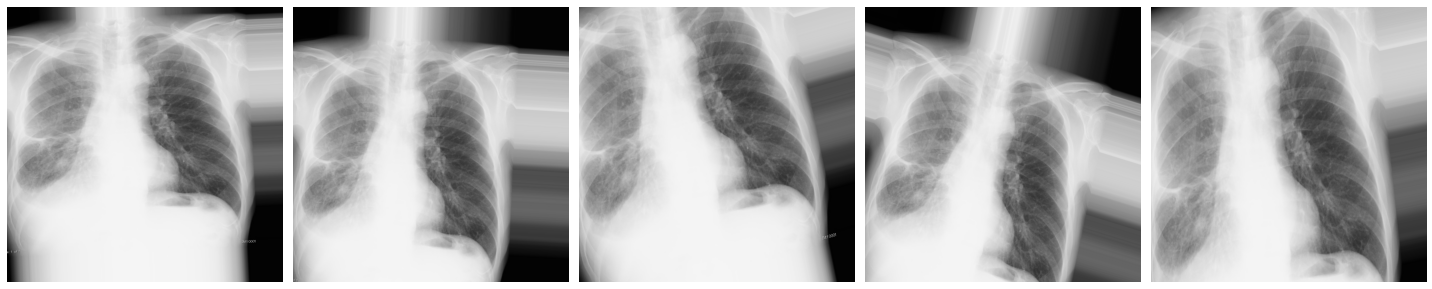

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [ ]:
val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                   directory=validation_dir,
                                                   shuffle=True,
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 8 images belonging to 2 classes.


In [ ]:
model_new = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_new.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 1024, 16)    448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 512, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 64)      0

In [ ]:
history = model_new.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val//8
)

Epoch 1/15


UnboundLocalError: ignored